# Logistic regression

In [28]:
%matplotlib inline
import numpy as np
import os,sys
from helpers import *
from plots import *

## Data extraction

In [29]:
# Load a set of images

n = 10 # Only use 10 images for training
root_dir = "Datasets/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

In [30]:
# Extract patches from all images (Note: AIcrowd expects patches of 16)
patch_size = 16

img_patches = extract_patches(imgs)
gt_patches = extract_patches(gt_imgs)

In [31]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

## Training and predictions

In [32]:
# train a logistic regression classifier

from sklearn import linear_model

# we create an instance of the classifier and fit the data
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced", solver="lbfgs")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))

True positive rate = 0.19728


In [34]:
# Predict on test set and create submission

dir_t = "Datasets/test_set_images/"
n_t = 50  # Number of test images

with open('Datasets/submission.csv', 'w') as f:
    f.write('id,prediction\n')

    for img_idx in range(1, n_t+1):
        image_path = dir_t + "test_{0}/test_{0}.png".format(img_idx)
        img = load_image(image_path)

        # Run predictions
        Xi_t = extract_img_features(image_path)
        Zi_t = logreg.predict(Xi_t)
        
        # Write predictions to file
        pred_index = 0
        for j in range(0, img.shape[1], patch_size):
            for i in range(0, img.shape[0], patch_size):
                f.write("{:03d}_{}_{},{}\n".format(img_idx, j, i, Zi_t[pred_index]))
                pred_index += 1

## Visualization of a single test image

In [35]:
# Load a test image
img_idx = 1

image_path = "Datasets/test_set_images/test_{0}/test_{0}.png".format(img_idx)
img = load_image(image_path)

In [36]:
# Run predictions
Xi = extract_img_features(image_path, patch_size)
Zi = logreg.predict(Xi)

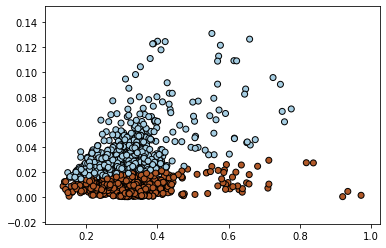

In [37]:
show_data_points(Xi, Zi)

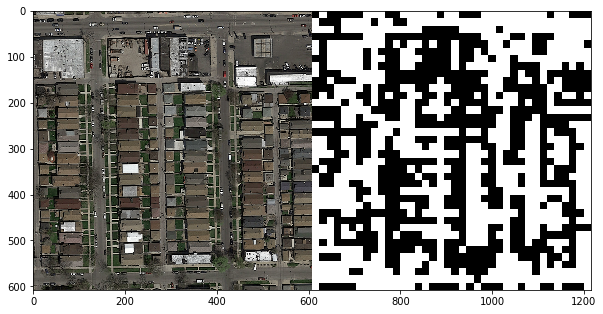

In [38]:
# Display prediction as an image
w = img.shape[0]
h = img.shape[1]
predicted_img = label_to_img(w, h, patch_size, patch_size, Zi)
show_img_concatenated(img, predicted_img)

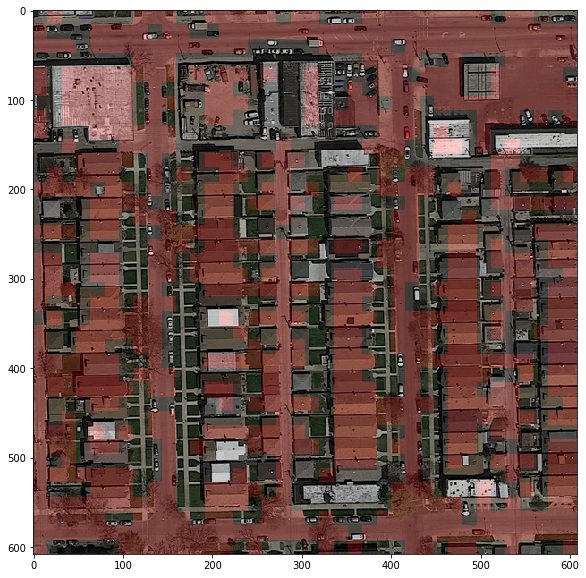

In [39]:
show_img_overlay(img, predicted_img)